In [3]:
from midiutil.MidiFile import MIDIFile
from itertools import combinations
from time import sleep
import subprocess
import numpy as np
import soundfile as sf
import os
import sounddevice as sd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import csv
from math import log10, floor

In [4]:
# load csv 
#015F887DB7FE9E2F,1.03,20,2.325,1,3.578,7,4.274,3,4.842,18,5.902,22,6.583,16,7.774,7,9.053,13,9.618,11,10.883,15,
#259D689DBD5445C6,1.24,7,2.454,2,11,3.074,9,17,5,3.662,16,4.405,23,18,5.499,23,19,6.098,18,18,7.064,5,2,13,7.604,9,3,8.742,19,9.496,5,19,1,10.181,3,8,2

In [193]:
def parse_row(csv_row):

    csv_row_array = csv_row.split(",")

    filename = csv_row_array[0]
    time_array = [float(t) for t in csv_row_array[1::2]]
    note_array = [int(x) for x in csv_row_array[2::2]]

    assert len(time_array) == len(note_array)

#     print(time_array)
#     print(note_array)

    return filename, time_array, note_array

In [194]:
csv_row = "06727653EA13A8BC,0.85,0,0.85,7,0.85,1,0.85,22,1.535,2,1.535,9,2.656,1,2.656,0,2.656,6,3.764,17,3.764,1,3.764,10,3.764,3,4.848,9,4.848,18,4.848,13,4.848,3,5.778,2,5.778,17,5.778,8,5.778,22,6.406,13,6.406,8,6.406,3,7.478,4,7.478,21,7.478,15,8.536,22,8.536,13,8.536,16,9.501,15,9.501,3,9.501,1,9.501,12,10.457,7,10.457,2,10.457,10,11.004,14,11.004,6,11.999,14,11.999,1,12.929,21,12.929,9,12.929,3,14.083,11,14.083,5,14.083,0,15.103,10,15.103,11,15.103,20,15.103,9,15.951,22,15.951,13,15.951,23,16.455,19,16.455,21,16.455,18,16.455,2,17.015,16,17.015,4,17.015,19,17.015,17,17.522,14,17.522,21,17.522,18,17.522,19,18.591,13,18.591,4,18.591,15,18.591,23,19.779,20,19.779,13,19.779,19,19.779,17,20.735,15,20.735,8,20.735,10"
filename, time_array, note_array = parse_row(csv_row)
print(time_array)
print(note_array)

[0.85, 0.85, 0.85, 0.85, 1.535, 1.535, 2.656, 2.656, 2.656, 3.764, 3.764, 3.764, 3.764, 4.848, 4.848, 4.848, 4.848, 5.778, 5.778, 5.778, 5.778, 6.406, 6.406, 6.406, 7.478, 7.478, 7.478, 8.536, 8.536, 8.536, 9.501, 9.501, 9.501, 9.501, 10.457, 10.457, 10.457, 11.004, 11.004, 11.999, 11.999, 12.929, 12.929, 12.929, 14.083, 14.083, 14.083, 15.103, 15.103, 15.103, 15.103, 15.951, 15.951, 15.951, 16.455, 16.455, 16.455, 16.455, 17.015, 17.015, 17.015, 17.015, 17.522, 17.522, 17.522, 17.522, 18.591, 18.591, 18.591, 18.591, 19.779, 19.779, 19.779, 19.779, 20.735, 20.735, 20.735]
[0, 7, 1, 22, 2, 9, 1, 0, 6, 17, 1, 10, 3, 9, 18, 13, 3, 2, 17, 8, 22, 13, 8, 3, 4, 21, 15, 22, 13, 16, 15, 3, 1, 12, 7, 2, 10, 14, 6, 14, 1, 21, 9, 3, 11, 5, 0, 10, 11, 20, 9, 22, 13, 23, 19, 21, 18, 2, 16, 4, 19, 17, 14, 21, 18, 19, 13, 4, 15, 23, 20, 13, 19, 17, 15, 8, 10]


In [195]:
def generate_midi_file(csv_row):
    filename, time_array, note_array = parse_row(csv_row)
    
    # create your MIDI object
    num_tracks = 5
    mf = MIDIFile(num_tracks)     # only 1 track
    track = 0   # the only track

    time = 0    # start at the beginning
#     mf.addTrackName(track, time, "Sample Track")
#     mf.addTempo(track, time, 120)

    # add some notes
    channel = 0
    volume = 100
    
    for i in range(len(time_array)):
        track = (track + 1) % 5
        
        pitch = 60 + note_array[i]             # C4 (middle C)
        time = time_array[i]                   # start on beat 0
        duration = np.random.uniform(0.8,0.9)
        volume = np.random.randint(50,100)     # 1 beat long
        mf.addNote(track, channel, pitch, time, duration, volume)
    
    with open("./midifiles/{}.mid".format(filename), 'wb') as outf:
        mf.writeFile(outf)
        
    return filename

In [196]:
generate_midi_file(csv_row)

'06727653EA13A8BC'

In [197]:
def convert_midi_to_signal(filename):
    '''
    Given filename, create soundfile.
    It uses fluidsynth to convert the midifile from the directory 
    into a soundfile in another directory.
    Installation of fluidsynth is necessary to run this.
    https://github.com/FluidSynth/fluidsynth/wiki/BuildingWithCMake
    returns mono signal - could we use stereo information for evaluation someday?
    '''
    soundfont_dir = "~/soundfonts/Sonatina_Symphonic_Orchestra.sf2"
    
    subprocess.run("fluidsynth -F ./soundfiles/{}.wav {} ./midifiles/{}.mid"
                   .format(filename,soundfont_dir,filename),shell=True)
    sleep(0.2)
    audio,sr = sf.read("./soundfiles/{}.wav".format(filename))
    if type(audio[0]) != float or type(audio[0]) != int: 
        # if stereo (expected)
        signal = audio[:,0]  
    else:    
        # if mono (but I have yet to try this out)
        signal = audio[:]
    assert (signal[0] != float or signal[0] != int)
    return signal

In [198]:
signal = convert_midi_to_signal(filename)

In [199]:
# save as spectrogram

def save_array(signal, filename):
    signal = signal[:44100*10]
    sd.play(signal)
    # signal += 0.0005*np.random.randn(len(signal))  # Gaussian
    signal += np.cumsum(0.0005*np.random.randn(len(signal)))  # Brownian
    fmin = librosa.core.note_to_hz("B3")
    cqt_array = librosa.cqt(signal, 
                            sr=44100, 
                            hop_length=2**7, 
                            bins_per_octave=36, 
                            fmin=fmin, 
                            n_bins=108)
    CQT = librosa.magphase(cqt_array)[0]
    assert np.shape(CQT) == (108,3446)
    plt.imshow(CQT)
    plt.show()
    np.save(filename, CQT)

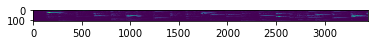

In [200]:
save_array(signal, filename)

(108, 3446)


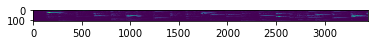

In [201]:
loaded_CQT = np.load(filename+".npy")
print(np.shape(loaded_CQT))
plt.imshow(loaded_CQT)
plt.show()

In [202]:
def convert_csv(csv_file):
    
    with open(csv_file, 'r') as csvfile:
        csv_rows = csvfile.read().split("\n")
        
    print(len(csv_rows))
        
    for csv_row in csv_rows:
        filename = generate_midi_file(csv_row)
        signal = convert_midi_to_signal(filename)
        save_array(signal, "./spectrograms/{}".format(filename))
        
        
#     for i,csv_row in 
#     return csv_rows


3


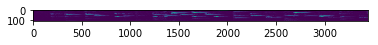

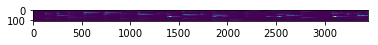

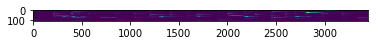

In [203]:
convert_csv('notes.csv')